In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
import seaborn as sns
import numpy as np
import joypy
import datetime
sns.set_palette("deep",desat=.6)
colors=sns.color_palette("deep")
sns.set_context(rc={"figure.figsize":(18,5)})
from bokeh.plotting import figure, output_file, show
%matplotlib inline

In [2]:
ridership=pd.read_excel(r"/Users/brianparker/Work/RidershipAutomation.xlsx")
ridership=pd.DataFrame(ridership)
ridership.set_index(['Stat','Service','Route','Area'],inplace=True)
ridership.columns=pd.to_datetime(ridership.columns,)

In [3]:
UPT_FR_FY18=ridership.loc[('UPT','FR'),datetime.datetime(year=2017,month=10,day=1):datetime.datetime(year=2018,month=10,day=1)]
UPT_FR_FY17=ridership.loc[('UPT','FR'),datetime.datetime(year=2016,month=10,day=1):datetime.datetime(year=2017,month=10,day=1)]

/anaconda2/envs/py3mapping/lib/python3.7/site-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [4]:
by_route18=UPT_FR_FY18.sum(axis=1)
by_route17=UPT_FR_FY17.sum(axis=1)

In [5]:
by_area18=by_route18.groupby('Area').sum()
by_area18=pd.DataFrame(by_area18)
by_area17=by_route17.groupby('Area').sum()
by_area17=pd.DataFrame(by_area17)

In [6]:
by_areaYTD=pd.concat([by_area18,by_area17],axis=1)
by_areaYTD.columns=['2018','2017']

In [7]:
#USE: Create an array structure for rings.
#INPUT: a df of row length 1 with the first column as the current metric value and the second colum is the target metric value
#OUTPUT: an aray of arrays representing each ring
def calculate_rings(df):
  if df.iloc[0,0] < df.iloc[0,1]:
    rings=[[df.iloc[0,0],df.iloc[0,1]-df.iloc[0,0]],[0,0]]
  elif df.iloc[0,0] / df.iloc[0,1] < 2:
    rings=[[df.iloc[0,0],0],[df.iloc[0,0] % df.iloc[0,1], df.iloc[0,1]-df.iloc[0,0] % df.iloc[0,1]]]
  else:
    rings = [[0,0],[0,0]]
  return rings

In [8]:
#USE: Determine if the label for the rotating number label should be left/center/right
#INPUT: a df of row length 1 with the first column as the current metric value and the second colum is the target metric value
#OUTPUT: the proper text alignment
def horizontal_aligner(df):
  metric = 1.0 * df.iloc[0,0] % df.iloc[0,1] / df.iloc[0,1]
  if metric in (0, 0.5):
    align = 'center'
  elif metric < 0.5:
    align = 'left'
  else:
    align = 'right'
  return align

In [9]:
def vertical_aligner(df):
  metric = 1.0 * df.iloc[0,0] % df.iloc[0,1] / df.iloc[0,1]
  if metric < 0.25:
    align = 'bottom'
  elif metric < 0.75:
    align = 'top'
  elif metric > 0.75:
    align = 'bottom'
  else:
    align = 'center'
  return align

In [10]:
#USE: Create a center label in the middle of the radial chart.
#INPUT: a df of row length 1 with the first column as the current metric value and the second column is the target metric value
#OUTPUT: the proper text label
def add_center_label(df):
    percent = str(round(1.0*df.iloc[0, 0]/df.iloc[0, 1]*100,1)) + '%'
    return plt.text(0,
           0.2,
           percent,
           horizontalalignment='center',
           verticalalignment='center',
           fontsize = 40,
           family = 'sans-serif')

In [11]:
#USE: Formats a number with the apropiate currency tags.
#INPUT: a currency number
#OUTPUT: the properly formmated currency string
def get_currency_label(num):
  currency = ''
  if num < 10**3:
    currency = str(num)
  elif num < 10**6:
      currency = str(round(1.0*num/10**3,1)) + 'K'
  elif df.iloc[0,0] < 10**9:
    currency = str(round(num/10**6,1)) + 'M'
  else:
    currency = tr(round(num/10**9,1)) + 'B'

  return currency

In [12]:
#USE: Create a dynamic outer label that servers a pointer on the ring.
#INPUT: a df of row length 1 with the first column as the current metric value and the second column is the target metric value
#OUTPUT: the proper text label at the apropiate position
def add_current_label(df):
  currency = 'FY18: '+get_currency_label(df.iloc[0,0])
  print('vertical: ' + vertical_aligner(df))
  print('horizontal: ' + horizontal_aligner(df))
  return plt.text(1.5 * np.cos(0.5 *np.pi - 2 * np.pi * (float(df.iloc[0,0]) % df.iloc[0,1] /df.iloc[0,1])),
           1.5 * np.sin(0.5 *np.pi - 2 * np.pi * (float(df.iloc[0,0]) % df.iloc[0,1] / df.iloc[0,1])),
                  currency,
                  horizontalalignment=horizontal_aligner(df),
                  verticalalignment=vertical_aligner(df),
                  fontsize = 20,
                  family = 'sans-serif')

In [13]:
def add_sub_center_label(df):
    amount = 'FY17: ' + get_currency_label(df.iloc[0,1])
    return plt.text(0,
            -.1,
            amount,
            horizontalalignment='center',
            verticalalignment='top',
            fontsize = 22,family = 'sans-serif')

#######################################################################
###                                                    MAIN FUNCTION                                                        ###
#######################################################################

In [26]:
def create_radial_chart(df, color_theme = 'Purples'):

    # base styling logic
    color = plt.get_cmap(color_theme) #+ 's')
    ring_width = 0.3
    outer_radius = 1.5
    inner_radius = outer_radius - (ring_width/2)

    # set up plot
    ring_arrays = calculate_rings(df)
    fig, ax = plt.subplots()

    if df.iloc[0, 0] > df.iloc[0, 1]:
        ring_to_label = 0
        outer_edge_color = None
        inner_edge_color = 'white'
    else:
        ring_to_label = 1
        outer_edge_color, inner_edge_color = ['white', None]

    # plot logic
    outer_ring, _ = ax.pie(ring_arrays[0],radius=1.5,
        colors=[color(0.9), color(0.15)],
        startangle = 90,
        counterclock = False)
    plt.setp( outer_ring, width=ring_width, edgecolor=outer_edge_color)

    inner_ring, _ = ax.pie(ring_arrays[1],
         radius=inner_radius,
         colors=[color(0.55), color(0.05)],
         startangle = 90,
         counterclock = False)
    plt.setp(inner_ring, width=ring_width/2, edgecolor=inner_edge_color)

    # add labels and format plots
    add_center_label(df)
    add_current_label(df)
    add_sub_center_label(df)
    ax.axis('equal')
    plt.margins(0,0)
    plt.autoscale('enable')

    return plt

In [27]:
by_areaAda=by_areaYTD.loc['Ada']
by_areaAda=pd.DataFrame(by_areaAda).T
by_areaCanyon=by_areaYTD.loc['Canyon']
by_areaCanyon=pd.DataFrame(by_areaCanyon).T
by_areaBSU=by_areaYTD.loc['Boise State']
by_areaBSU=pd.DataFrame(by_areaBSU).T
by_areaIC=by_areaYTD.loc['Intercounty']
by_areaIC=pd.DataFrame(by_areaIC).T

NameError: name 'df' is not defined

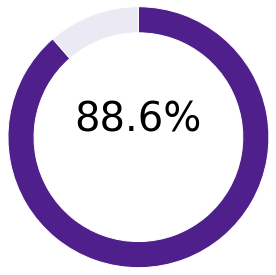

In [28]:
create_radial_chart(by_areaAda)

vertical: bottom
horizontal: left


<module 'matplotlib.pyplot' from '/anaconda2/envs/py3mapping/lib/python3.7/site-packages/matplotlib/pyplot.py'>

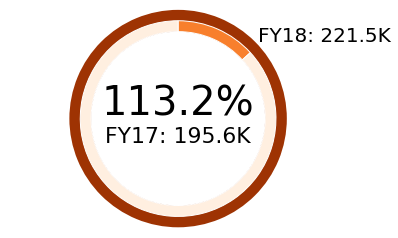

In [29]:
create_radial_chart(by_areaBSU,color_theme='Oranges')

vertical: top
horizontal: left


<module 'matplotlib.pyplot' from '/anaconda2/envs/py3mapping/lib/python3.7/site-packages/matplotlib/pyplot.py'>

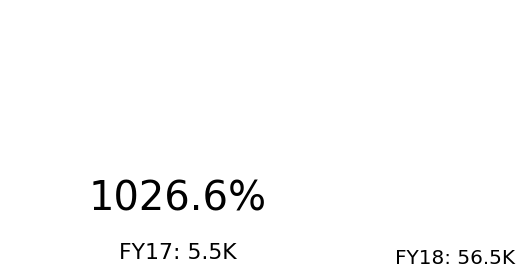

In [19]:
create_radial_chart(by_areaCanyon)

vertical: bottom
horizontal: left


<module 'matplotlib.pyplot' from '/anaconda2/envs/py3mapping/lib/python3.7/site-packages/matplotlib/pyplot.py'>

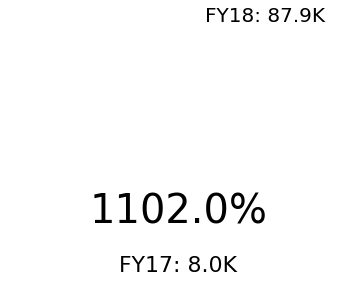

In [20]:
create_radial_chart(by_areaIC)

In [21]:
by_area_change=by_areaYTD['2018']/by_areaYTD['2017']
by_area_change

Area
Ada             0.886007
Boise State     1.132207
Canyon         10.265529
Intercounty    11.019925
dtype: float64

(<a list of 4 Line2D gridline objects>,
 <a list of 4 Text major ticklabel objects>)

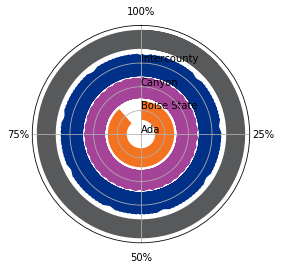

In [22]:
ax=plt.subplot(projection='polar')
ax.barh(1,(np.radians(by_area_change['Ada'])*360),color='#F37321')
ax.barh(2,np.radians(by_area_change['Canyon'])*360,color='#A54399')
ax.barh(3,np.radians(by_area_change['Intercounty'])*360,color='#003087')
ax.barh(4,np.radians(by_area_change['Boise State'])*360,color='#58595B')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_thetagrids([0,90,180,270],labels=['100%','25%','50%','75%'])
ax.set_rgrids([0,1,2,3],labels=by_area_change.index)

In [23]:
parkcenter18=ridership.loc[('UPT','FR','1 Parkcenter'),datetime.datetime(year=2017,month=10,day=1):datetime.datetime(year=2018,month=10,day=1)].sum(axis=1)
parkcenter17=ridership.loc[('UPT','FR','1 Parkcenter'),datetime.datetime(year=2016,month=10,day=1):datetime.datetime(year=2017,month=10,day=1)].sum(axis=1)
parkcenterYTD=pd.concat([parkcenter18,parkcenter17],axis=1)
parkcenterYTD.columns=['2018','2017']
parkcenterYTD

,2018,2017
Area,,
Ada,73101.0,79747.0


vertical: bottom
horizontal: right


<module 'matplotlib.pyplot' from '/anaconda2/envs/py3mapping/lib/python3.7/site-packages/matplotlib/pyplot.py'>

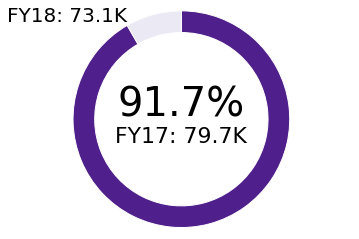

In [24]:
create_radial_chart(parkcenterYTD)

In [25]:
ax.barh([0, 1, 2, 3], np.radians([150, 300, 270, 320]),
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'])

<BarContainer object of 4 artists>